## SigLIP - 400M (Better than CLIP)

Replaces Softmax loss with Sigmoid Loss, since Softmax Loss is computationally expensive comparing with all other text descriptions. Sigmoid Loss makes it focus on individual image-text pair.

[Youtube Video](https://www.youtube.com/watch?v=4XgDdxpXHEQ)


In [1]:
from transformers import AutoProcessor, SiglipVisionModel, SiglipVisionConfig

processor = AutoProcessor.from_pretrained('google/siglip-base-patch16-224') # Patch size: 16, Image size: 224 * 224
vision_model = SiglipVisionModel.from_pretrained(
    'google/siglip-base-patch16-224', 
    config=SiglipVisionConfig(vision_use_head=False)
    )

vision_model

c:\Users\yashs\miniconda3\envs\learn\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


SiglipVisionModel(
  (vision_model): SiglipVisionTransformer(
    (embeddings): SiglipVisionEmbeddings(
      (patch_embedding): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16), padding=valid)
      (position_embedding): Embedding(196, 768)
    )
    (encoder): SiglipEncoder(
      (layers): ModuleList(
        (0-11): 12 x SiglipEncoderLayer(
          (self_attn): SiglipSdpaAttention(
            (k_proj): Linear(in_features=768, out_features=768, bias=True)
            (v_proj): Linear(in_features=768, out_features=768, bias=True)
            (q_proj): Linear(in_features=768, out_features=768, bias=True)
            (out_proj): Linear(in_features=768, out_features=768, bias=True)
          )
          (layer_norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
          (mlp): SiglipMLP(
            (activation_fn): PytorchGELUTanh()
            (fc1): Linear(in_features=768, out_features=3072, bias=True)
            (fc2): Linear(in_features=3072, out_features=768, bi

## Input

In [2]:
import torch

from torch import nn
from torch.nn import functional as F
from dataclasses import dataclass
from PIL import Image
from torchvision import transforms


def preprocess_image(image, image_size=224):
    preprocess = transforms.Compose([
        transforms.Resize((image_size, image_size)),
        transforms.ToTensor(),
        transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )                                       # Values from ImageNet Dataset (Most Optimal/Industry Standard)
    ])

    image_tensor = preprocess(image)

    # [3, 224, 224] -> unsqueeze -> [1, 3, 224, 224] 
    # (Includes the "Batch-dimension" for Tensors)
    image_tensor = image_tensor.unsqueeze(0)
    
    return image_tensor

img = Image.open('cat.jpg')
image_tensor = preprocess_image(img)

## Embedding Block

### Patch Embedding

In [3]:
# SigLIP parameters
embed_dim = 768
patch_size = 16
image_size = 224
num_patches = (image_size // patch_size) ** 2

# Not in Training Mode. Compute the image patches using Conv2d
with torch.no_grad():
    patch_embedding = nn.Conv2d(
        in_channels=3, 
        out_channels=embed_dim, 
        kernel_size=patch_size,
        stride=patch_size
    )

    patches = patch_embedding(image_tensor)

patches.shape, num_patches

(torch.Size([1, 768, 14, 14]), 196)

### Position Embeddings

In [4]:
# Look-up table for all the position embeddings
position_embedding = nn.Embedding(num_patches, embed_dim)

# Adding the batch dimension for the tensors
position_ids = torch.arange(num_patches).expand((1, -1))

position_ids.shape

torch.Size([1, 196])

### Merging the outputs

In [5]:
# [1, 768, 14, 14] -> flatten -> [1, 768, 196]
embeddings = patches.flatten(start_dim=2, end_dim=-1)

# Transpose to match the position-embedding dimensions. [1, 768, 196] -> transpose -> [1, 196, 768]
embeddings = embeddings.transpose(1, 2)

embeddings = embeddings + position_embedding(position_ids)

embeddings.shape

torch.Size([1, 196, 768])

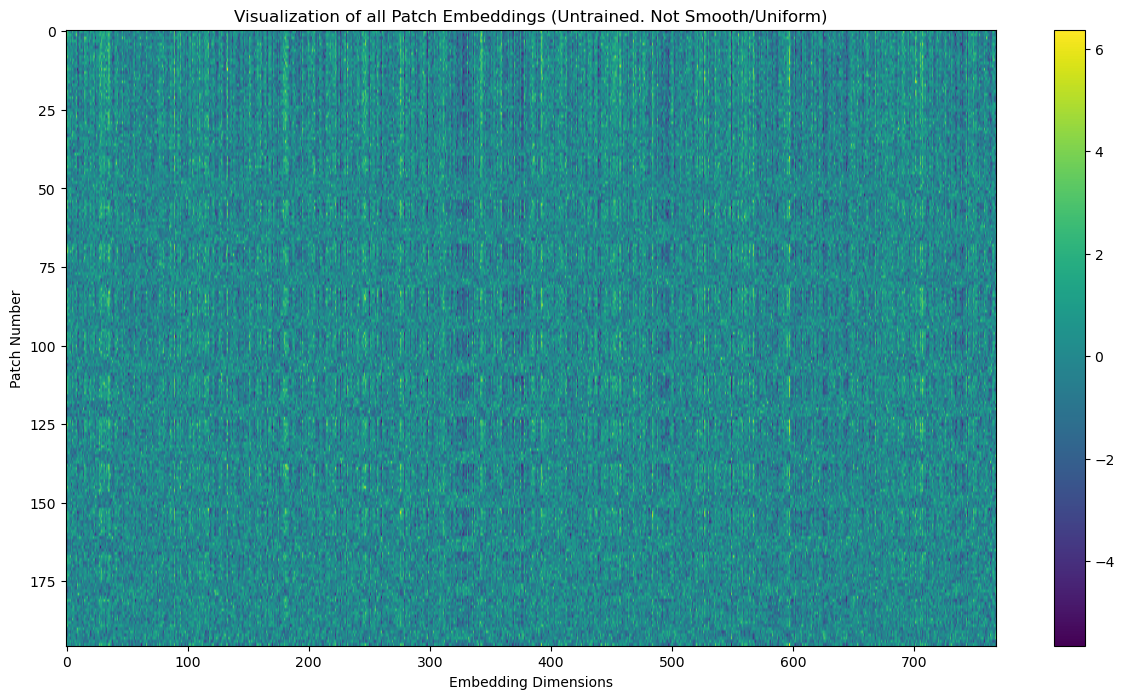

In [6]:
import matplotlib.pyplot as plt

patch_vix = embeddings[0].detach().numpy()

plt.figure(figsize=(15, 8))
plt.imshow(patch_vix, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Visualization of all Patch Embeddings (Untrained. Not Smooth/Uniform)")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Patch Number")
plt.show()

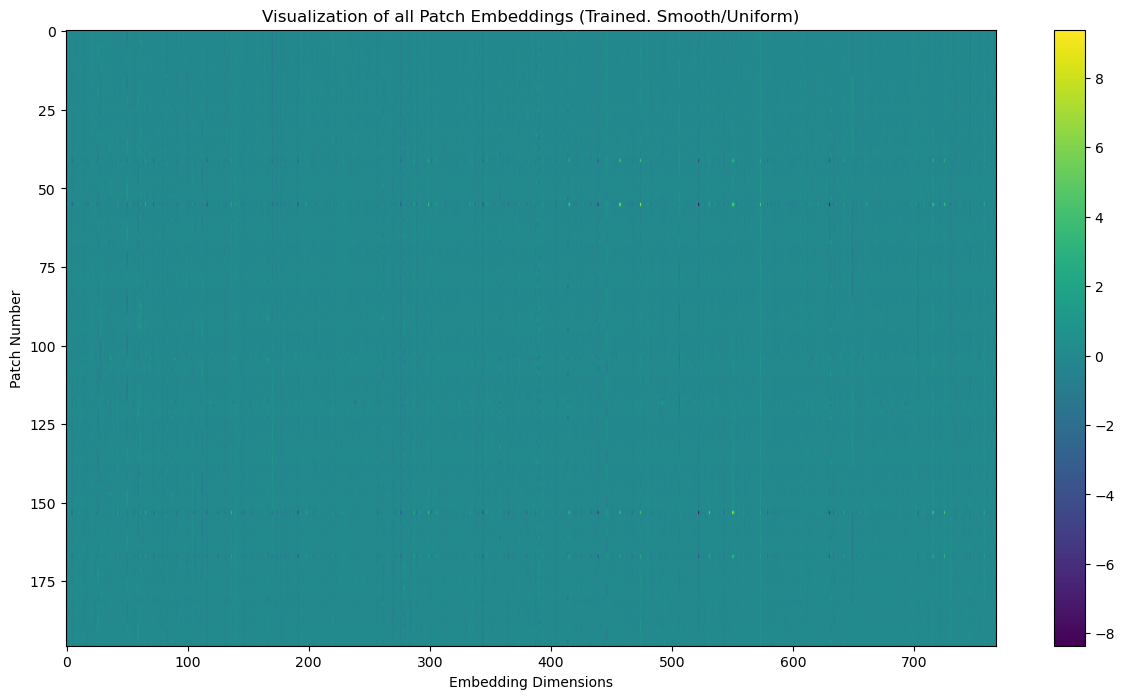

In [7]:
import matplotlib.pyplot as plt

inputs = processor(images=img, return_tensors='pt')

with torch.no_grad():
    temp_embeddings = vision_model.vision_model.embeddings(inputs.pixel_values)

temp_vix = temp_embeddings[0].detach().numpy()

plt.figure(figsize=(15, 8))
plt.imshow(temp_vix, aspect='auto', cmap='viridis')
plt.colorbar()
plt.title("Visualization of all Patch Embeddings (Trained. Smooth/Uniform)")
plt.xlabel("Embedding Dimensions")
plt.ylabel("Patch Number")
plt.show()

### Combining the embedding process under a class

In [8]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    hidden_size: int = 768
    image_size: int = 224
    patch_size: int = 16

class SiglipVisionEmbeddings(nn.Module):
    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config

        self.num_channels = config.num_channels
        self.hidden_size = config.hidden_size
        self.image_size = config.image_size
        self.patch_size = config.patch_size

        self.patch_embedding = nn.Conv2d(
            in_channels = self.num_channels,
            out_channels = self.hidden_size,
            kernel_size = self.patch_size,
            stride = self.patch_size,
            padding = 'valid'
        )

        self.num_patches = (self.image_size // self.patch_size) ** 2
        self.position_embedding = nn.Embedding(self.num_patches, self.hidden_size)

        '''
        Parameters in the model, which should be saved and restored in the state_dict, 
        but not trained by the optimizer, should be registerd as buffers.
        Buffers won’t be returned in model.parameters(), so that the optimizer won’t 
        have a change to update them.
        '''
        self.register_buffer(
            "position_ids",
            torch.arange(self.num_patches).expand((1, -1)),
            persistent=False
        )

    def forward(self, pixel_values: torch.FloatTensor) -> torch.Tensor:
        # Batch, Channel, Height, Width
        B, C, H, W = pixel_values.shape

        patch_embeds = self.patch_embedding(pixel_values)
        embeddings = patch_embeds.flatten(start_dim=2, end_dim=-1)
        embeddings = embeddings.transpose(1, 2)
        embeddings = embeddings + self.position_embedding(self.position_ids)
        return embeddings

In [9]:
embd = SiglipVisionEmbeddings(SiglipVisionConfig())
embd(image_tensor).shape

torch.Size([1, 196, 768])

In [10]:
our_state_dict = embd.state_dict()
hf_state_dict = {k.replace("vision_model.embeddings.", ""): v
                for k, v in vision_model.state_dict().items()
                if "vision_model.embeddings." in k}

our_state_dict.update(hf_state_dict)
embd.load_state_dict(our_state_dict)

with torch.no_grad():
    our_output = embd(image_tensor)
    hf_output = vision_model.vision_model.embeddings(image_tensor)
    print("Max Diff:", torch.max(torch.abs(our_output - hf_output)))

Max Diff: tensor(0.)


## Encoder Block

### Multi-head Attention

In [11]:
import math

class Head(nn.Module):
    ''' A single head of the multi-head attention '''

    def __init__(self, n_in, n_out, context_length):
        super().__init__()
        self.head_size = n_out
        self.key = nn.Linear(n_in, n_out, bias=False)
        self.query = nn.Linear(n_in, n_out, bias=False)
        self.value = nn.Linear(n_in, n_out, bias=False)

    def forward(self, x):
        # Batch, Token, Channel/Embedding
        B, T, C = x.shape
        
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        
        wei = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(self.head_size))
        wei = F.softmax(wei, dim=-1)
        out = wei @ v

        return out


class MultiHeadAttention(nn.Module):
    ''' 
    Multi-head Attention implementation with 
    concatenating every head's output
    '''

    def __init__(self, num_head, n_in, n_out, context_length):
        super().__init__()
        self.num_head = num_head
        self.head_size = n_out
        self.heads = [Head(n_in, n_out, context_length) for _ in range(num_head)]
        self.proj = nn.Linear(n_in, n_in)

    def foward(self, x):
        out = [h(x) for h in self.heads]
        out = torch.concat(out, -1)
        out = self.proj(out)
        return out


### Hugging-Face Implementation

In [12]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0

class SiglipVisionAttention(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config

        self.embed_dim = config.hidden_size
        self.num_heads = config.num_attention_heads
        self.dropout = config.attention_dropout

        self.k_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.q_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.v_proj = nn.Linear(self.embed_dim, self.embed_dim)
        self.out_proj = nn.Linear(self.embed_dim, self.embed_dim)

    def forward(self, hidden_states):
        '''
        hidden_states are the embeddings of the image patches.
        (batch_size, num_patches, embed_dim)
        '''

        B, T, C = hidden_states.shape

        k_states = self.k_proj(hidden_states)
        q_states = self.q_proj(hidden_states)
        v_states = self.v_proj(hidden_states)

        k_states = k_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        q_states = q_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)
        v_states = v_states.view(B, T, self.num_heads, C // self.num_heads).transpose(1, 2)

        attn_weights = (q_states @ k_states.transpose(-2, -1)) * (1.0 / math.sqrt(k_states.size(-1)))
        attn_weights = F.softmax(attn_weights, dim=-1).to(q_states.dtype)
        attn_weights = F.dropout(attn_weights, p=self.dropout, training=self.training)
        
        attn_outs = attn_weights @ v_states
        attn_outs = attn_outs.transpose(1, 2)
        attn_outs = attn_outs.reshape(B, T, C).contiguous()
        attn_outs = self.out_proj(attn_outs)

        return attn_outs


batch_size = 1
num_patches = 196
embed_dim = 768

hidden_states = torch.randn(batch_size, num_patches, embed_dim)
config = SiglipVisionConfig(
    attention_dropout = 0.0,
    num_attention_heads = 12,
    hidden_size = 768
)
attention = SiglipVisionAttention(config)
output = attention(hidden_states)

output.shape

torch.Size([1, 196, 768])

### MLP

In [13]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0
    intermediate_size = 3072


class SiglipVisionMLP(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config

        self.fc1 = nn.Linear(config.hidden_size, config.intermediate_size)
        self.fc2 = nn.Linear(config.intermediate_size, config.hidden_size)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        out = self.fc1(hidden_states)
        out = F.gelu(out, approximate='tanh')
        out = self.fc2(out)

        return out


batch_size = 1
num_patches = 196
embed_dim = 768

hidden_states = torch.randn(batch_size, num_patches, embed_dim)
mlp = SiglipVisionMLP(SiglipVisionConfig())
mlp(hidden_states).shape

torch.Size([1, 196, 768])

### Encoder-Layer Implementation


HIDDEN-STATES ---> Layer-Norm ---> Multi-Head Attention --(+RESIDUAL)--> Layer-Norm ---> MLP --(+RESIDUAL)--> OUTPUT

In [14]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0
    intermediate_size = 3072
    layer_norm_eps = 1e-6


class SiglipVisionEncoderLayer(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.embed_dim = config.hidden_size
        self.self_attn = SiglipVisionAttention(config)
        self.layer_norm1 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)
        self.mlp = SiglipVisionMLP(config)
        self.layer_norm2 = nn.LayerNorm(self.embed_dim, eps=config.layer_norm_eps)

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        residual = hidden_states
        out1 = self.layer_norm1(hidden_states)
        out1 = self.self_attn(out1)
        out1 = out1 + residual

        residual = out1
        out2 = self.layer_norm2(out1)
        out2 = self.mlp(out2)
        out2 = out2 + residual

        return out2


encoder_layer = SiglipVisionEncoderLayer(SiglipVisionConfig())
encoder_layer(hidden_states).shape



torch.Size([1, 196, 768])

## Transformer Implementation

In [15]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0
    intermediate_size = 3072
    layer_norm_eps = 1e-6
    num_encoder = 12


class SiglipVisionEncoder(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config

        self.encoders = [SiglipVisionEncoderLayer(config) for _ in range(config.num_encoder)]

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        for encoder in self.encoders:
            hidden_states = encoder(hidden_states)
        
        return hidden_states

encoder = SiglipVisionEncoder(SiglipVisionConfig)
encoder(hidden_states).shape

torch.Size([1, 196, 768])

## Transformer Implementation

In [16]:
@dataclass
class SiglipVisionConfig:
    num_channels: int = 3
    image_size: int = 224
    patch_size: int = 16
    num_attention_heads: int = 12
    hidden_size: int = 768
    attention_dropout: float = 0.0
    intermediate_size = 3072
    layer_norm_eps = 1e-6
    num_encoder = 12


class SiglipVisionTransformer(nn.Module):

    def __init__(self, config: SiglipVisionConfig):
        super().__init__()
        self.config = config

        self.embeddings = SiglipVisionEmbeddings(config)
        self.encoder = SiglipVisionEncoder(config)
        self.post_layer_norm = nn.LayerNorm(config.hidden_size, eps=config.layer_norm_eps)

    def forward(self, pixel_values: torch.Tensor) -> torch.Tensor:
        hidden_states = self.embeddings(pixel_values)
        out = self.encoder(hidden_states)
        out = self.post_layer_norm(out)

        return out


transformer = SiglipVisionTransformer(SiglipVisionConfig())
transformer(image_tensor).shape

torch.Size([1, 196, 768])